### Read in the US county level shapefile to be able to merge with the voter data. 
This will let us see by county all of the votes per each candidate over each election year. 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pyproj
import rasterio
import rasterstats
import pandas as pd
import json
from rasterio.mask import mask
from rasterio.plot import show
import matplotlib.colors as pltc
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterstats import zonal_stats
import matplotlib.patches as mpatches

In [2]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [3]:
# shapefile
counties = gpd.read_file("C:/Users/ml124/Box/Jared's Project (shared)/Madi/shapefiles/us_counties_2017.shp")
counties.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,01,005,00161528,0500000US01005,01005,Barbour,06,2292144656,50538698,"POLYGON ((-85.74803 31.61918, -85.74544 31.618..."
1,01,023,00161537,0500000US01023,01023,Choctaw,06,2365869837,19144469,"POLYGON ((-88.47323 31.89386, -88.46888 31.930..."
2,01,035,00161543,0500000US01035,01035,Conecuh,06,2201948618,6643480,"POLYGON ((-87.42720 31.26436, -87.42551 31.268..."
3,01,051,00161551,0500000US01051,01051,Elmore,06,1601762124,99965171,"POLYGON ((-86.41333 32.75059, -86.37115 32.750..."
4,01,065,00161558,0500000US01065,01065,Hale,06,1667907107,32423356,"POLYGON ((-87.87046 32.76244, -87.86818 32.765..."


In [4]:
state_fips_to_names = {
    '01': 'Alabama', '02': 'Alaska', '04': 'Arizona', '05': 'Arkansas', '06': 'California',
    '08': 'Colorado', '09': 'Connecticut', '10': 'Delaware', '11': 'District of Columbia', 
    '12': 'Florida', '13': 'Georgia', '15': 'Hawaii', '16': 'Idaho', '17': 'Illinois', 
    '18': 'Indiana', '19': 'Iowa', '20': 'Kansas', '21': 'Kentucky', '22': 'Louisiana', 
    '23': 'Maine', '24': 'Maryland', '25': 'Massachusetts', '26': 'Michigan', '27': 'Minnesota', 
    '28': 'Mississippi', '29': 'Missouri', '30': 'Montana', '31': 'Nebraska', '32': 'Nevada', 
    '33': 'New Hampshire', '34': 'New Jersey', '35': 'New Mexico', '36': 'New York', 
    '37': 'North Carolina', '38': 'North Dakota', '39': 'Ohio', '40': 'Oklahoma', '41': 'Oregon', 
    '42': 'Pennsylvania', '44': 'Rhode Island', '45': 'South Carolina', '46': 'South Dakota', 
    '47': 'Tennessee', '48': 'Texas', '49': 'Utah', '50': 'Vermont', '51': 'Virginia', 
    '53': 'Washington', '54': 'West Virginia', '55': 'Wisconsin', '56': 'Wyoming'
}

In [5]:
counties['STATE_NAME'] = counties['STATEFP'].replace(state_fips_to_names)
counties.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,STATE_NAME
0,01,005,00161528,0500000US01005,01005,Barbour,06,2292144656,50538698,"POLYGON ((-85.74803 31.61918, -85.74544 31.618...",Alabama
1,01,023,00161537,0500000US01023,01023,Choctaw,06,2365869837,19144469,"POLYGON ((-88.47323 31.89386, -88.46888 31.930...",Alabama
2,01,035,00161543,0500000US01035,01035,Conecuh,06,2201948618,6643480,"POLYGON ((-87.42720 31.26436, -87.42551 31.268...",Alabama
3,01,051,00161551,0500000US01051,01051,Elmore,06,1601762124,99965171,"POLYGON ((-86.41333 32.75059, -86.37115 32.750...",Alabama
4,01,065,00161558,0500000US01065,01065,Hale,06,1667907107,32423356,"POLYGON ((-87.87046 32.76244, -87.86818 32.765...",Alabama


<Axes: >

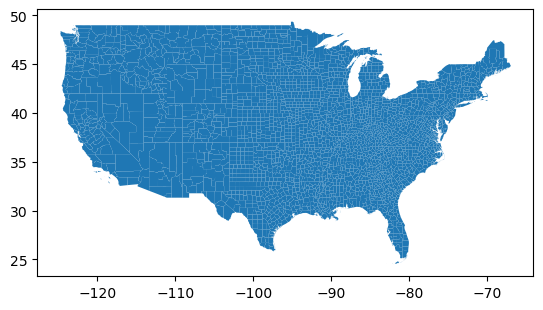

In [6]:
counties = counties[~counties['STATE_NAME'].isin(["Alaska","Hawaii","Puerto Rico",'60','66', '69', '72', '78'])]
counties['random'] = np.random.rand(len(counties))

counties.plot()

In [7]:
# Adjust the file path as needed
voter_data_path = 'C:/Users/ml124/Box/Jared\'s Project (shared)/Madi/countypres_2000-2020.csv'
df_voter = pd.read_csv(voter_data_path)
df_voter

,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,totalvotes,version,mode
0,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,AL GORE,DEMOCRAT,4942,17208,20220315,TOTAL
1,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,GEORGE W. BUSH,REPUBLICAN,11993,17208,20220315,TOTAL
2,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,RALPH NADER,GREEN,160,17208,20220315,TOTAL
3,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,OTHER,OTHER,113,17208,20220315,TOTAL
4,2000,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,AL GORE,DEMOCRAT,13997,56480,20220315,TOTAL
...,...,...,...,...,...,...,...,...,...,...,...,...
72612,2020,WYOMING,WY,WASHAKIE,56043.0,US PRESIDENT,DONALD J TRUMP,REPUBLICAN,3245,4032,20220315,TOTAL
72613,2020,WYOMING,WY,WESTON,56045.0,US PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,360,3560,20220315,TOTAL
72614,2020,WYOMING,WY,WESTON,56045.0,US PRESIDENT,JO JORGENSEN,LIBERTARIAN,46,3560,20220315,TOTAL
72615,2020,WYOMING,WY,WESTON,56045.0,US PRESIDENT,OTHER,OTHER,47,3560,20220315,TOTAL


There are NA values in the FIPS variable for the voter data, and it's very small amount of observations. Half of them don't have voter data at all, so going to drop NA values there. 

In [8]:
# First, ensure there are no NaN values that would cause type conversion errors
df_voter = df_voter.dropna(subset=['county_fips'])

# Convert 'county_fips' to integer, then to string with leading zeros using .loc
df_voter.loc[:, 'county_fips'] = df_voter['county_fips'].astype(int).astype(str).str.zfill(5)


In [9]:
# Merging on FIPS code which is common to both the shapefile and voter data
counties['FIPS'] = counties['STATEFP'] + counties['COUNTYFP']  # Create a full FIPS code if it doesn't exist
merged_data = counties.merge(df_voter, left_on='FIPS', right_on='county_fips', how='left')


In [10]:
# Checking the columns and head just to see if everything was added properly
print(merged_data.head())
print(counties.columns)  
print(df_voter.columns)  
print(merged_data.columns)

  STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID     NAME LSAD       ALAND  \
0      01      005  00161528  0500000US01005  01005  Barbour   06  2292144656   
1      01      005  00161528  0500000US01005  01005  Barbour   06  2292144656   
2      01      005  00161528  0500000US01005  01005  Barbour   06  2292144656   
3      01      005  00161528  0500000US01005  01005  Barbour   06  2292144656   
4      01      005  00161528  0500000US01005  01005  Barbour   06  2292144656   

     AWATER                                           geometry  ... state_po  \
0  50538698  POLYGON ((-85.74803 31.61918, -85.74544 31.618...  ...       AL   
1  50538698  POLYGON ((-85.74803 31.61918, -85.74544 31.618...  ...       AL   
2  50538698  POLYGON ((-85.74803 31.61918, -85.74544 31.618...  ...       AL   
3  50538698  POLYGON ((-85.74803 31.61918, -85.74544 31.618...  ...       AL   
4  50538698  POLYGON ((-85.74803 31.61918, -85.74544 31.618...  ...       AL   

   county_name county_fips      

### Presidential Election 2000

In [11]:
# Prepare the data
data_2000 = merged_data[(merged_data['year'] == 2000) & (merged_data['office'] == 'US PRESIDENT')].copy()
data_2000['vote_share'] = data_2000['candidatevotes'] / data_2000['totalvotes']

# Find the winner by county
max_votes = data_2000.groupby('GEOID')['vote_share'].transform('max')  # Use the string 'max' to avoid future issues
data_2000['max_vote_share'] = max_votes
data_2000['winner'] = data_2000['vote_share'] == data_2000['max_vote_share']


In [12]:
# Mapping colors to parties for clarity in visualization
party_colors = {
    'DEMOCRAT': 'blue',
    'REPUBLICAN': 'red',
    'GREEN': 'green',
    'OTHER': 'grey', 
    'LIBERTARIAN': 'orange'
}

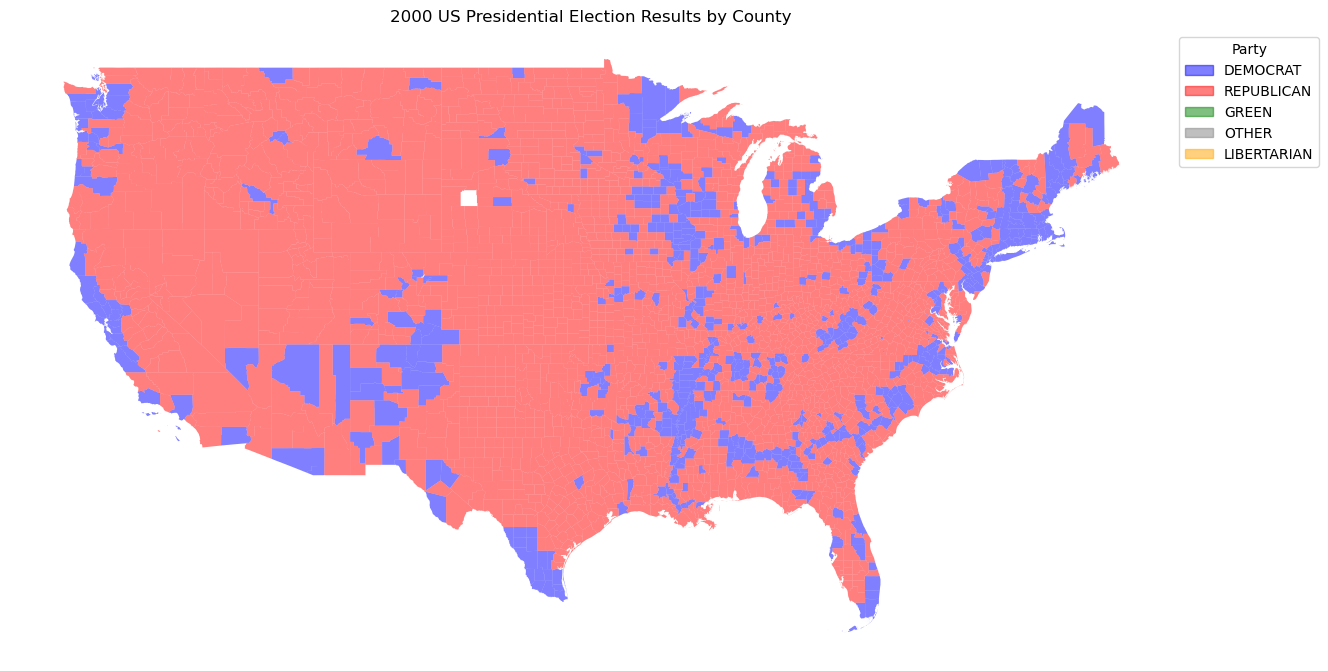

In [13]:
# Plotting
fig, ax = plt.subplots(1, figsize=(15, 10))
ax.set_aspect('equal')  # This helps prevent the ValueError related to aspect

# Plot each candidate by vote share but only for the winner in each county
for party, color in party_colors.items():
    subset = data_2000[(data_2000['party'].str.upper() == party) & data_2000['winner']]
    if not subset.empty:
        subset.plot(ax=ax, color=color, alpha=0.5, label=party)

# Create a legend
    legend_handles = [mpatches.Patch(color=color, alpha=0.5, label=party) for party, color in party_colors.items()]
    ax.legend(handles=legend_handles, title="Party", loc='upper left', bbox_to_anchor=(1, 1))

# Customize further as needed
ax.set_title('2000 US Presidential Election Results by County')
ax.set_axis_off()

# Save the figure
file_path = "C:/Users/ml124/Box/Jared\'s Project (shared)/Madi/2000_election_results.jpg"  # Specify your file path here
fig.savefig(file_path, format='jpeg')  # Save as JPEG

plt.show()

### Presidential Election 2004

In [14]:
# Prepare the data
data_2004 = merged_data[(merged_data['year'] == 2004) & (merged_data['office'] == 'US PRESIDENT')].copy()
data_2004['vote_share'] = data_2004['candidatevotes'] / data_2004['totalvotes']

# Find the winner by county
max_votes = data_2004.groupby('GEOID')['vote_share'].transform('max')  # Use the string 'max' to avoid future issues
data_2004['max_vote_share'] = max_votes
data_2004['winner'] = data_2004['vote_share'] == data_2004['max_vote_share']

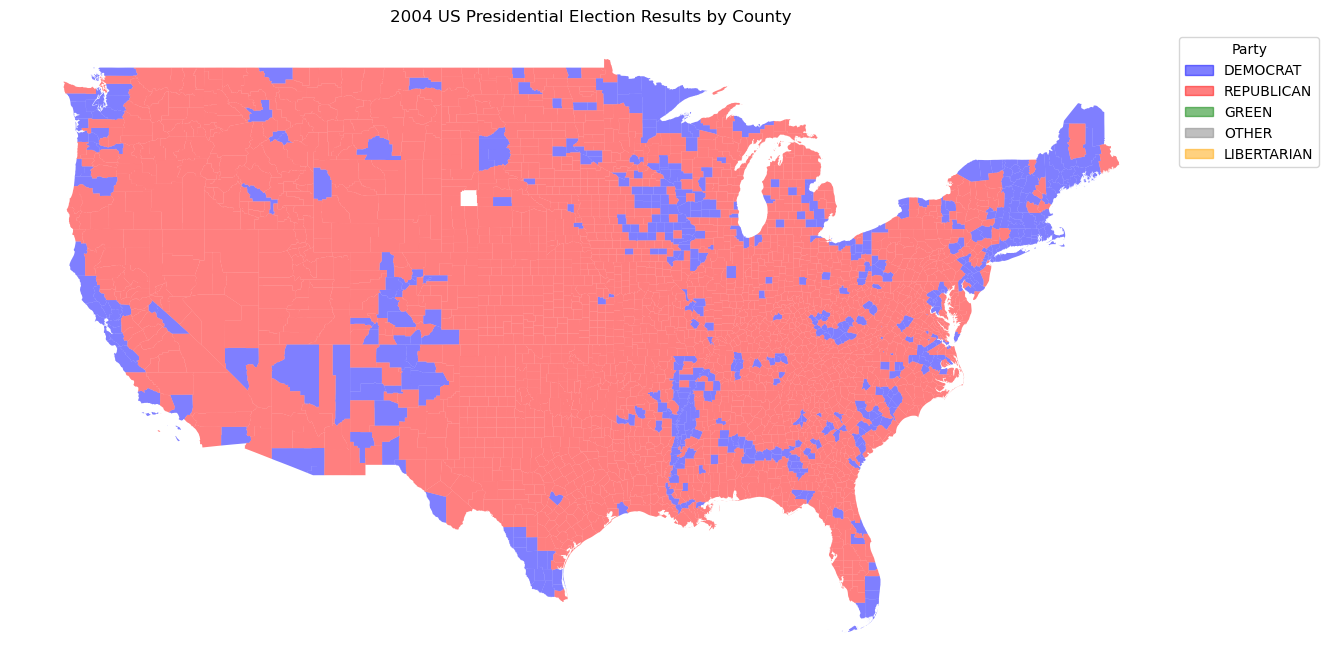

In [15]:
# Plotting
fig, ax = plt.subplots(1, figsize=(15, 10))
ax.set_aspect('equal')  # This helps prevent the ValueError related to aspect

# Plot each candidate by vote share but only for the winner in each county
for party, color in party_colors.items():
    subset = data_2004[(data_2004['party'].str.upper() == party) & data_2004['winner']]
    if not subset.empty:
        subset.plot(ax=ax, color=color, alpha=0.5, label=party)

# Create a legend
    legend_handles = [mpatches.Patch(color=color, alpha=0.5, label=party) for party, color in party_colors.items()]
    ax.legend(handles=legend_handles, title="Party", loc='upper left', bbox_to_anchor=(1, 1))

# Customize further as needed
ax.set_title('2004 US Presidential Election Results by County')
ax.set_axis_off()

# Save the figure
file_path = "C:/Users/ml124/Box/Jared\'s Project (shared)/Madi/2004_election_results.jpg"  # Specify your file path here
fig.savefig(file_path, format='jpeg')  # Save as JPEG

plt.show()

### Presidential Election 2008


In [16]:
# Prepare the data
data_2008 = merged_data[(merged_data['year'] == 2008) & (merged_data['office'] == 'US PRESIDENT')].copy()
data_2008['vote_share'] = data_2008['candidatevotes'] / data_2008['totalvotes']

# Find the winner by county
max_votes = data_2008.groupby('GEOID')['vote_share'].transform('max')  # Use the string 'max' to avoid future issues
data_2008['max_vote_share'] = max_votes
data_2008['winner'] = data_2008['vote_share'] == data_2008['max_vote_share']

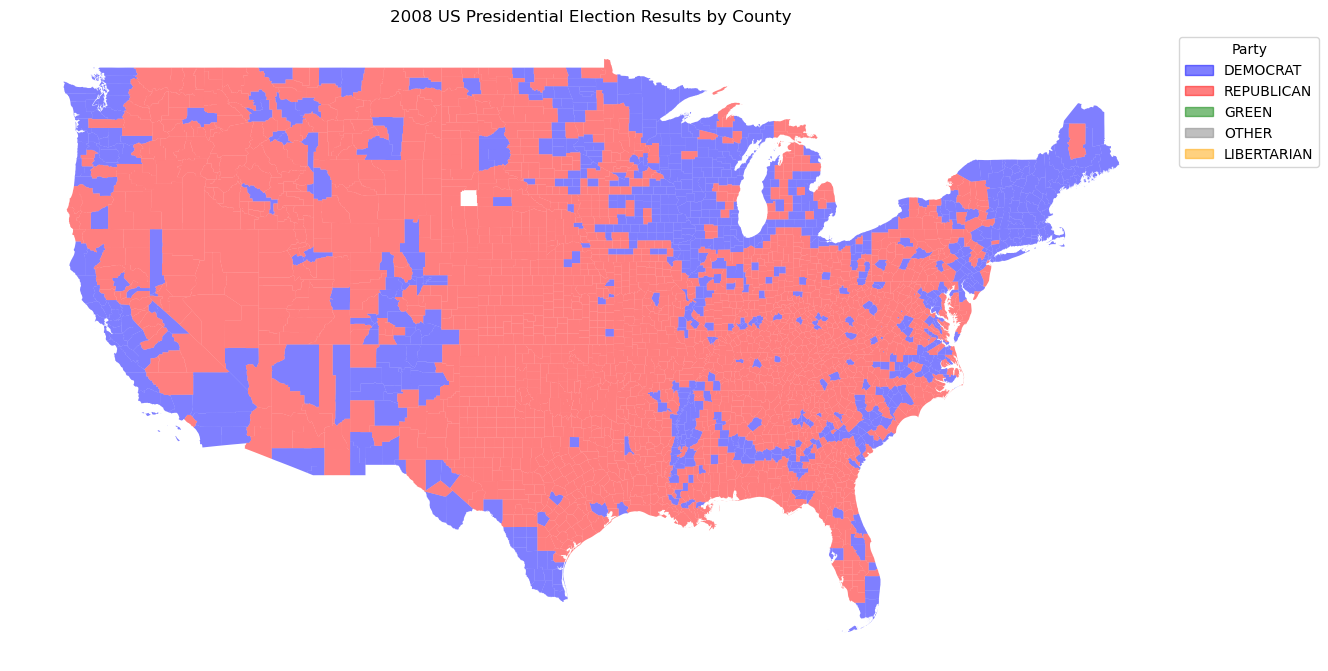

In [17]:
# Plotting
fig, ax = plt.subplots(1, figsize=(15, 10))
ax.set_aspect('equal')  # This helps prevent the ValueError related to aspect

# Plot each candidate by vote share but only for the winner in each county
for party, color in party_colors.items():
    subset = data_2008[(data_2008['party'].str.upper() == party) & data_2008['winner']]
    if not subset.empty:
        subset.plot(ax=ax, color=color, alpha=0.5, label=party)

# Create a legend
    legend_handles = [mpatches.Patch(color=color, alpha=0.5, label=party) for party, color in party_colors.items()]
    ax.legend(handles=legend_handles, title="Party", loc='upper left', bbox_to_anchor=(1, 1))

# Customize further as needed
ax.set_title('2008 US Presidential Election Results by County')
ax.set_axis_off()

# Save the figure
file_path = "C:/Users/ml124/Box/Jared\'s Project (shared)/Madi/2008_election_results.jpg"  # Specify your file path here
fig.savefig(file_path, format='jpeg')  # Save as JPEG

plt.show()

### Presidential election 2012


In [18]:
# Prepare the data
data_2012 = merged_data[(merged_data['year'] == 2012) & (merged_data['office'] == 'US PRESIDENT')].copy()
data_2012['vote_share'] = data_2012['candidatevotes'] / data_2012['totalvotes']

# Find the winner by county
max_votes = data_2012.groupby('GEOID')['vote_share'].transform('max')  # Use the string 'max' to avoid future issues
data_2012['max_vote_share'] = max_votes
data_2012['winner'] = data_2012['vote_share'] == data_2012['max_vote_share']

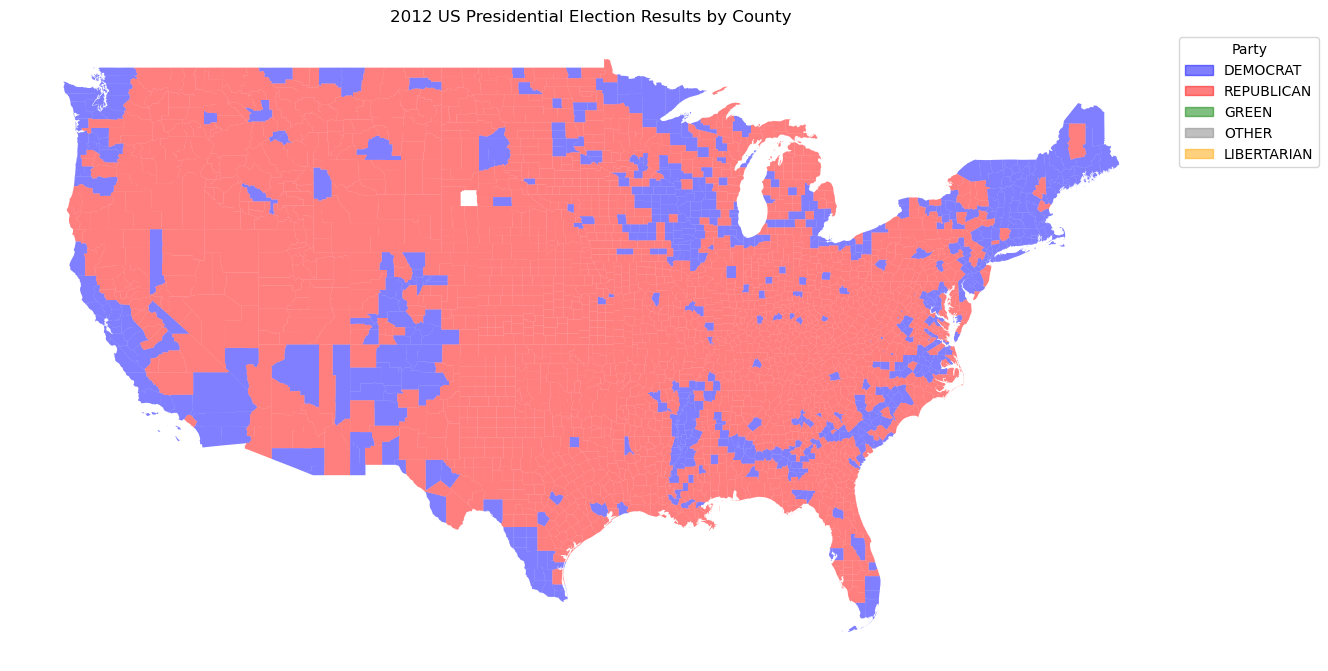

In [19]:
# Plotting
fig, ax = plt.subplots(1, figsize=(15, 10))
ax.set_aspect('equal')  # This helps prevent the ValueError related to aspect

# Plot each candidate by vote share but only for the winner in each county
for party, color in party_colors.items():
    subset = data_2012[(data_2012['party'].str.upper() == party) & data_2012['winner']]
    if not subset.empty:
        subset.plot(ax=ax, color=color, alpha=0.5, label=party)

# Create a legend
    legend_handles = [mpatches.Patch(color=color, alpha=0.5, label=party) for party, color in party_colors.items()]
    ax.legend(handles=legend_handles, title="Party", loc='upper left', bbox_to_anchor=(1, 1))

# Customize further as needed
ax.set_title('2012 US Presidential Election Results by County')
ax.set_axis_off()

# Save the figure
file_path = "C:/Users/ml124/Box/Jared\'s Project (shared)/Madi/2012_election_results.jpg"  # Specify your file path here
fig.savefig(file_path, format='jpeg')  # Save as JPEG

plt.show()

### Presidential Election 2016

In [20]:
# Prepare the data
data_2016 = merged_data[(merged_data['year'] == 2016) & (merged_data['office'] == 'US PRESIDENT')].copy()
data_2016['vote_share'] = data_2016['candidatevotes'] / data_2016['totalvotes']

# Find the winner by county
max_votes = data_2016.groupby('GEOID')['vote_share'].transform('max')  # Use the string 'max' to avoid future issues
data_2016['max_vote_share'] = max_votes
data_2016['winner'] = data_2016['vote_share'] == data_2016['max_vote_share']

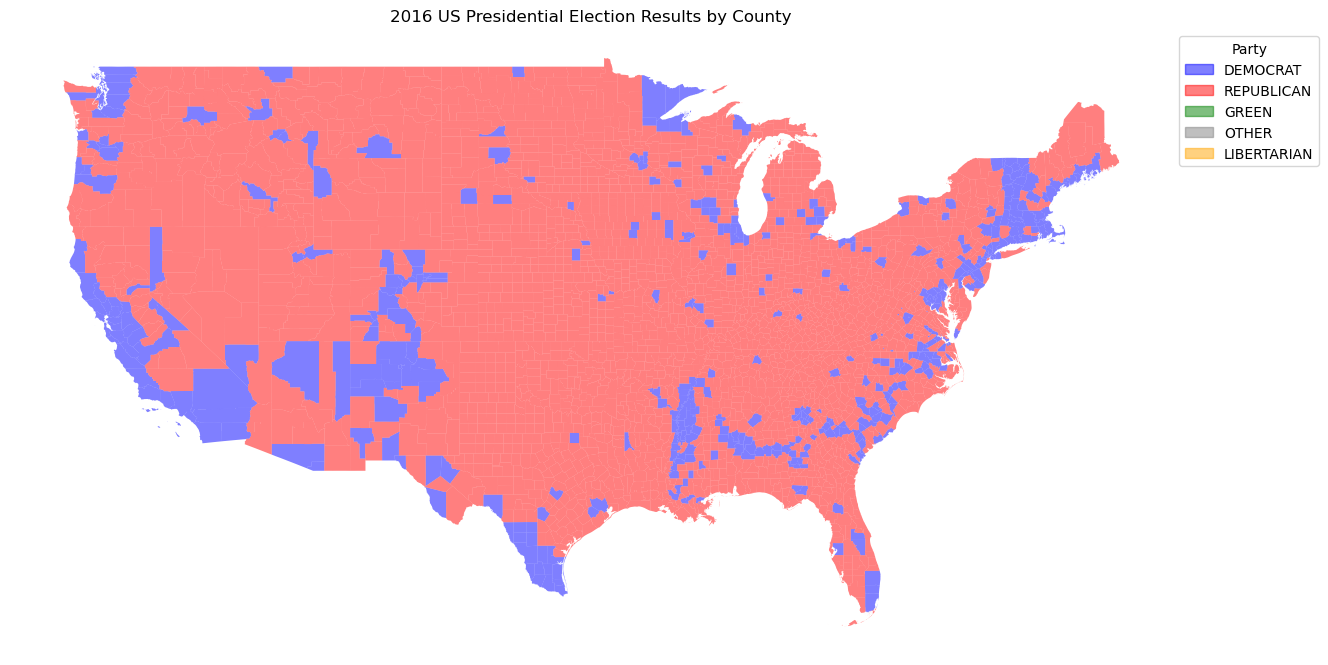

In [21]:
# Plotting
fig, ax = plt.subplots(1, figsize=(15, 10))
ax.set_aspect('equal')  # This helps prevent the ValueError related to aspect

# Plot each candidate by vote share but only for the winner in each county
for party, color in party_colors.items():
    subset = data_2016[(data_2016['party'].str.upper() == party) & data_2016['winner']]
    if not subset.empty:
        subset.plot(ax=ax, color=color, alpha=0.5, label=party)

# Create a legend
    legend_handles = [mpatches.Patch(color=color, alpha=0.5, label=party) for party, color in party_colors.items()]
    ax.legend(handles=legend_handles, title="Party", loc='upper left', bbox_to_anchor=(1, 1))

# Customize further as needed
ax.set_title('2016 US Presidential Election Results by County')
ax.set_axis_off()

# Save the figure
file_path = "C:/Users/ml124/Box/Jared\'s Project (shared)/Madi/2016_election_results.jpg"  # Specify your file path here
fig.savefig(file_path, format='jpeg')  # Save as JPEG

plt.show()

### Presidential Election 2020

In [22]:
# Prepare the data
data_2020 = merged_data[(merged_data['year'] == 2020) & (merged_data['office'] == 'US PRESIDENT')].copy()
data_2020['vote_share'] = data_2020['candidatevotes'] / data_2020['totalvotes']

# Find the winner by county
max_votes = data_2020.groupby('GEOID')['vote_share'].transform('max')  # Use the string 'max' to avoid future issues
data_2020['max_vote_share'] = max_votes
data_2020['winner'] = data_2020['vote_share'] == data_2020['max_vote_share']

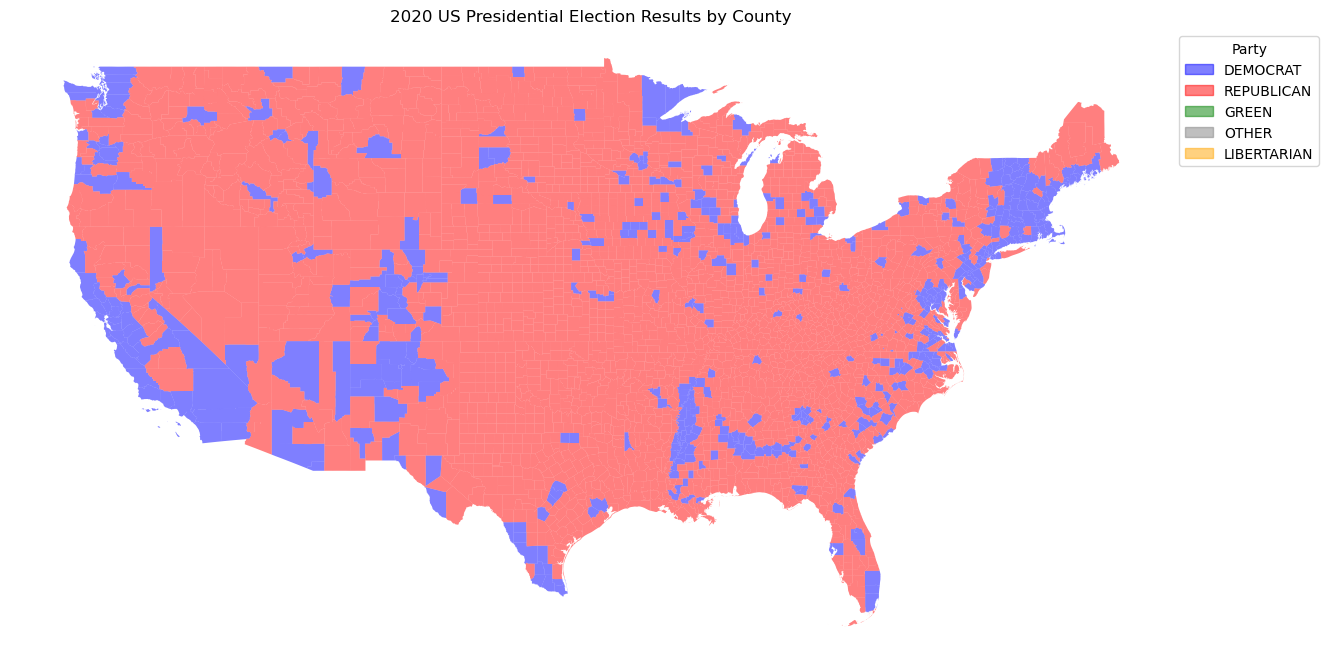

In [23]:
# Plotting
fig, ax = plt.subplots(1, figsize=(15, 10))
ax.set_aspect('equal')  # This helps prevent the ValueError related to aspect

# Plot each candidate by vote share but only for the winner in each county
for party, color in party_colors.items():
    subset = data_2020[(data_2020['party'].str.upper() == party) & data_2020['winner']]
    if not subset.empty:
        subset.plot(ax=ax, color=color, alpha=0.5, label=party)

# Create a legend
    legend_handles = [mpatches.Patch(color=color, alpha=0.5, label=party) for party, color in party_colors.items()]
    ax.legend(handles=legend_handles, title="Party", loc='upper left', bbox_to_anchor=(1, 1))

# Customize further as needed
ax.set_title('2020 US Presidential Election Results by County')
ax.set_axis_off()

# Save the figure
file_path = "C:/Users/ml124/Box/Jared\'s Project (shared)/Madi/2020_election_results.jpg"  # Specify your file path here
fig.savefig(file_path, format='jpeg')  # Save as JPEG

plt.show()

### Lets try to get the Payment data now to get pre-election and Farm Bill years. 
For instance there are the Farm Bill in 2002, 2007/08, 2013, and 2018. So we would want to aggregate 2005-2008, then 2009-2012 (the Farm Bill was being discussed), 2013-2016 (the Farm Bill was supposed to be inacted in 2017 but actually was done in 2018). Then we can do 2017-2020 to see if there is anything. 

In [24]:
# Path to the CSV file
file_path = "C:/Users/ml124/Box/Jared's Project (shared)/Khashi/CRP_data.csv"

# Initialize an empty list to store mean values
means = []

# Read the CSV file in chunks
chunk_iter = pd.read_csv(file_path, chunksize=100000, low_memory=False)

# Process each chunk
for chunk in chunk_iter:
    # Group by state, county, year, and description and compute the mean disbursement
    mean = chunk.groupby(['State FSA Name', 'County FSA Name', 'Payment Year'])['Disbursement Amount'].mean()
    means.append(mean)

# Concatenate all mean DataFrames
final_means = pd.concat(means)

# Reset the index to turn the series into a DataFrame
final_means_df = final_means.reset_index()

# Optionally, save this DataFrame to a new CSV if you need to use it separately
final_means_df.to_csv("C:/Users/ml124/Box/Jared's Project (shared)/Madi/mean_disbursements.csv", index=False)

# If you need to pivot this table for any reason:
pivot_df = final_means_df.pivot_table(index=['State FSA Name', 'County FSA Name'],
                                      columns='Payment Year',
                                      values='Disbursement Amount')

# Save the pivot table if necessary
pivot_df.to_csv("C:/Users/ml124/Box/Jared's Project (shared)/Madi/pivot_disbursements.csv")


In [25]:
final_means_df.head(250)

,State FSA Name,County FSA Name,Payment Year,Disbursement Amount
0,Alabama,Autauga,2008.0,7297.000000
1,Alabama,Autauga,2020.0,4046.800000
2,Alabama,Baldwin,2008.0,10057.328000
3,Alabama,Baldwin,2020.0,1786.958333
4,Alabama,Barbour,2020.0,1344.896024
...,...,...,...,...
245,California,Humboldt,2013.0,742.750000
246,California,Kern,2013.0,46597.000000
247,California,Lassen,2013.0,941.000000
248,California,Los Angeles,2013.0,2630.440000


In [26]:
pivot_df.head(50)

Payment Year                       2008.0       2009.0       2010.0  2011.0  \
State FSA Name County FSA Name                                                
Alabama        Autauga           7297.000  2784.618209  2606.798061     NaN   
               Baldwin          10057.328  1339.018810  1427.562841     NaN   
               Barbour                NaN  1650.903394          NaN     NaN   
               Bibb                   NaN          NaN          NaN     NaN   
               Blount                 NaN          NaN          NaN     NaN   
               Bullock                NaN          NaN          NaN     NaN   
               Butler                 NaN          NaN          NaN     NaN   
               Calhoun                NaN          NaN          NaN     NaN   
               Chambers               NaN          NaN          NaN     NaN   
               Cherokee               NaN          NaN          NaN     NaN   
               Chilton                NaN          NaN          NaN     NaN   
               Choctaw                NaN          NaN          NaN     NaN   
               Clarke                 NaN          NaN          NaN     NaN   
               Clay                   NaN          NaN          NaN     NaN   
               Cleburne               NaN          NaN          NaN     NaN   
               Coffee                 NaN          NaN          NaN     NaN   
               Colbert                NaN          NaN          NaN     NaN   
               Conecuh                NaN          NaN          NaN     NaN   
               Coosa                  NaN          NaN          NaN     NaN   
               Covington              NaN          NaN          NaN     NaN   
               Crenshaw               NaN          NaN          NaN     NaN   
               Cullman                NaN          NaN          NaN     NaN   
               Dale                   NaN          NaN          NaN     NaN   
               Dallas                 NaN          NaN          NaN     NaN   
               DeKalb                 NaN          NaN          NaN     NaN   
               Elmore                 NaN          NaN          NaN     NaN   
               Escambia               NaN          NaN          NaN     NaN   
               Etowah                 NaN          NaN          NaN     NaN   
               Fayette                NaN          NaN          NaN     NaN   
               Franklin               NaN          NaN          NaN     NaN   
               Geneva                 NaN          NaN          NaN     NaN   
               Greene                 NaN          NaN          NaN     NaN   
               Hale                   NaN          NaN          NaN     NaN   
               Henry                  NaN          NaN          NaN     NaN   
               Houston                NaN          NaN          NaN     NaN   
               Jackson                NaN          NaN          NaN     NaN   
               Lamar                  NaN          NaN          NaN     NaN   
               Lauderdale             NaN          NaN          NaN     NaN   
               Lawrence               NaN          NaN          NaN     NaN   
               Lee                    NaN          NaN          NaN     NaN   
               Limestone              NaN          NaN          NaN     NaN   
               Lowndes                NaN          NaN          NaN     NaN   
               Macon                  NaN          NaN          NaN     NaN   
               Madison                NaN          NaN          NaN     NaN   
               Marengo                NaN          NaN          NaN     NaN   
               Marion                 NaN          NaN          NaN     NaN   
               Marshall               NaN          NaN          NaN     NaN   
               Mobile                 NaN          NaN          NaN     NaN   
               Monroe                 NaN         

### Now this is summing the years prior to elections and for the farm bill.

In [27]:
# Sum disbursements by the specified periods
pivot_df['2008'] = pivot_df[[2008]].sum(axis=1, skipna=True)
pivot_df['2009-2012'] = pivot_df[[2009, 2010, 2011, 2012]].sum(axis=1, skipna=True)
pivot_df['2013-2016'] = pivot_df[[2013, 2014, 2015, 2016]].sum(axis=1, skipna=True)
pivot_df['2017-2020'] = pivot_df[[2017, 2018, 2019, 2020]].sum(axis=1, skipna=True)

# Check the new columns to ensure they've been added correctly
print(pivot_df[['2008', '2009-2012', '2013-2016', '2017-2020']].head())


Payment Year                         2008    2009-2012     2013-2016  \
State FSA Name County FSA Name                                         
Alabama        Autauga           7297.000  5391.416270  10585.142081   
               Baldwin          10057.328  2766.581650   4917.467685   
               Barbour              0.000  1650.903394   4303.045021   
               Bibb                 0.000     0.000000   6280.204545   
               Blount               0.000     0.000000   3376.212452   

Payment Year                       2017-2020  
State FSA Name County FSA Name                
Alabama        Autauga          16938.571229  
               Baldwin           6854.031618  
               Barbour           5584.556307  
               Bibb              7388.893667  
               Blount            4218.643417  


In [28]:
pivot_df.head()

Payment Year                       2008.0       2009.0       2010.0  2011.0  \
State FSA Name County FSA Name                                                
Alabama        Autauga           7297.000  2784.618209  2606.798061     NaN   
               Baldwin          10057.328  1339.018810  1427.562841     NaN   
               Barbour                NaN  1650.903394          NaN     NaN   
               Bibb                   NaN          NaN          NaN     NaN   
               Blount                 NaN          NaN          NaN     NaN   

Payment Year                    2012.0  2013.0       2014.0       2015.0  \
State FSA Name County FSA Name                                             
Alabama        Autauga             NaN     NaN  2960.400000  3415.921569   
               Baldwin             NaN     NaN  1648.221622  1636.353659   
               Barbour             NaN     NaN  1439.855011  1430.624476   
               Bibb                NaN     NaN  2349.000000  1852.454545   
               Blount              NaN     NaN  1093.475000  1122.594595   

Payment Year                         2016.0       2017.0       2018.0  \
State FSA Name County FSA Name                                          
Alabama        Autauga          4208.820513  4565.062500  4314.676471   
               Baldwin          1632.892405  1658.808219  1672.619048   
               Barbour          1432.565534  1383.714286  1474.676875   
               Bibb             2078.750000  2108.125000  1509.768667   
               Blount           1160.142857  1101.275862  1011.344828   

Payment Year                         2019.0       2020.0  2021.0       2022.0  \
State FSA Name County FSA Name                                                  
Alabama        Autauga          4012.032258  4046.800000     NaN  4580.818182   
               Baldwin          1735.646018  1786.958333     NaN  1651.705882   
               Barbour          1381.269122  1344.896024     NaN  1499.542653   
               Bibb             1885.200000  1885.800000     NaN  1282.800000   
               Blount           1007.250000  1098.772727     NaN   815.333333   

Payment Year                         2023.0       2008    2009-2012  \
State FSA Name County FSA Name                                        
Alabama        Autauga          4140.727273   7297.000  5391.416270   
               Baldwin          1823.541176  10057.328  2766.581650   
               Barbour          1444.224299      0.000  1650.903394   
               Bibb              849.800000      0.000     0.000000   
               Blount            813.500000      0.000     0.000000   

Payment Year                       2013-2016     2017-2020  
State FSA Name County FSA Name                              
Alabama        Autauga          10585.142081  16938.571229  
               Baldwin           4917.467685   6854.031618  
               Barbour           4303.045021   5584.556307  
               Bibb              6280.204545   7388.893667  
               Blount            3376.212452   4218.643417

### What we will do now is try to merge this back with the shapefile to be able to plot years. 

In [29]:
print(pivot_df.columns)


Index([     2008.0,      2009.0,      2010.0,      2011.0,      2012.0,
            2013.0,      2014.0,      2015.0,      2016.0,      2017.0,
            2018.0,      2019.0,      2020.0,      2021.0,      2022.0,
            2023.0,      '2008', '2009-2012', '2013-2016', '2017-2020'],
      dtype='object', name='Payment Year')


In [30]:
# Reset the index so that State FSA Name and County FSA Name are regular columns
pivot_df.reset_index(inplace=True)

# Now rename the columns to match those in your counties DataFrame
pivot_df.rename(columns={'State FSA Name': 'STATE_NAME', 'County FSA Name': 'COUNTY_NAME'}, inplace=True)


In [31]:
# Ensure the data types are compatible, particularly that the merging fields are both strings
pivot_df['STATE_NAME'] = pivot_df['STATE_NAME'].astype(str)
pivot_df['COUNTY_NAME'] = pivot_df['COUNTY_NAME'].astype(str)
counties['STATE_NAME'] = counties['STATE_NAME'].astype(str)
counties['NAME'] = counties['NAME'].astype(str)


In [32]:
# Merge the GeoDataFrame with the payment data
merged_data = counties.merge(pivot_df, left_on=['STATE_NAME', 'NAME'], right_on=['STATE_NAME', 'COUNTY_NAME'], how='left')

# Check the merge
print(merged_data.head())

  STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID     NAME LSAD       ALAND  \
0      01      005  00161528  0500000US01005  01005  Barbour   06  2292144656   
1      01      023  00161537  0500000US01023  01023  Choctaw   06  2365869837   
2      01      035  00161543  0500000US01035  01035  Conecuh   06  2201948618   
3      01      051  00161551  0500000US01051  01051   Elmore   06  1601762124   
4      01      065  00161558  0500000US01065  01065     Hale   06  1667907107   

     AWATER                                           geometry  ...  \
0  50538698  POLYGON ((-85.74803 31.61918, -85.74544 31.618...  ...   
1  19144469  POLYGON ((-88.47323 31.89386, -88.46888 31.930...  ...   
2   6643480  POLYGON ((-87.42720 31.26436, -87.42551 31.268...  ...   
3  99965171  POLYGON ((-86.41333 32.75059, -86.37115 32.750...  ...   
4  32423356  POLYGON ((-87.87046 32.76244, -87.86818 32.765...  ...   

        2018.0       2019.0       2020.0 2021.0       2022.0       2023.0  \
0  1474.6

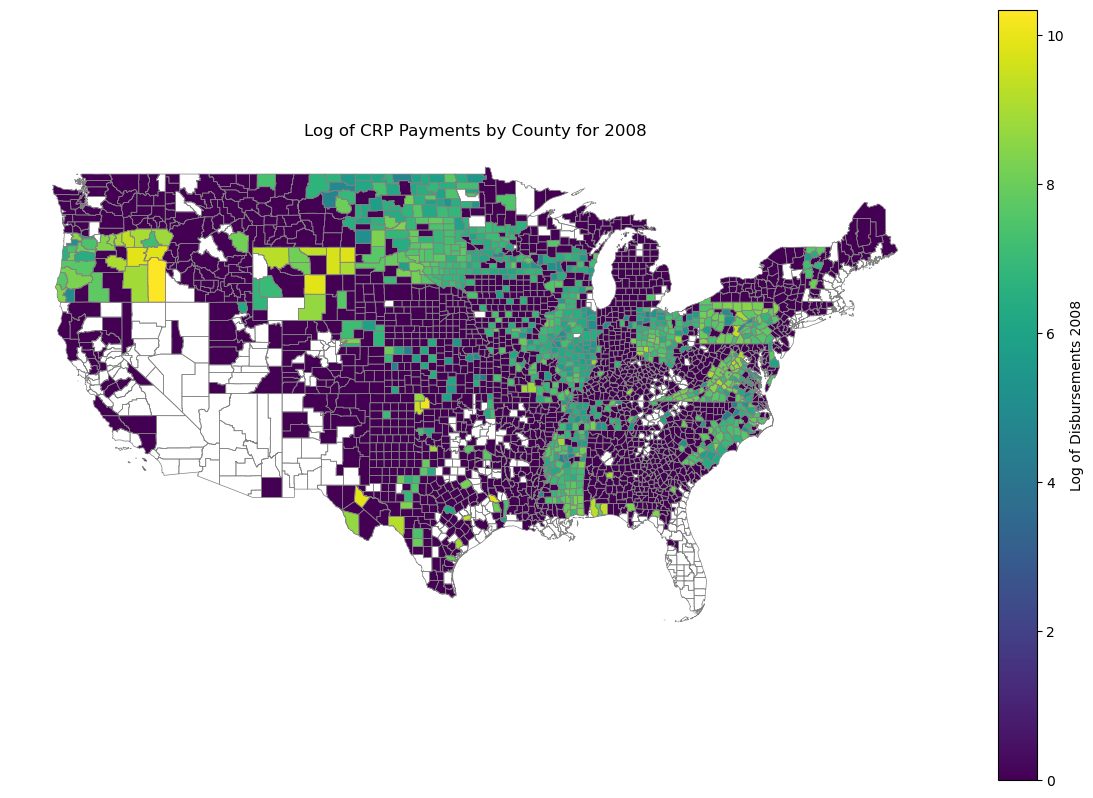

In [34]:
# Transform disbursements to logarithmic scale where necessary before plotting
# Use log1p to safely handle zero and near-zero values by adding 1 before log transformation
merged_data['log_2008'] = np.log1p(merged_data['2008'])

fig, ax = plt.subplots(1, figsize=(15, 10))
# Plot the counties with log-transformed data
merged_data.plot(column='log_2008', ax=ax, legend=True,
                 legend_kwds={'label': "Log of Disbursements 2008", 'orientation': "vertical"})

# Plot all county outlines for context
counties.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=0.5)

ax.set_title('Log of CRP Payments by County for 2008')
ax.set_axis_off()

# Save the figure
file_path = "C:/Users/ml124/Box/Jared's Project (shared)/Madi/2008_payments.jpg"  # Specify your file path here
fig.savefig(file_path, format='jpeg', dpi=300)  # Save as JPEG with high resolution
plt.show()

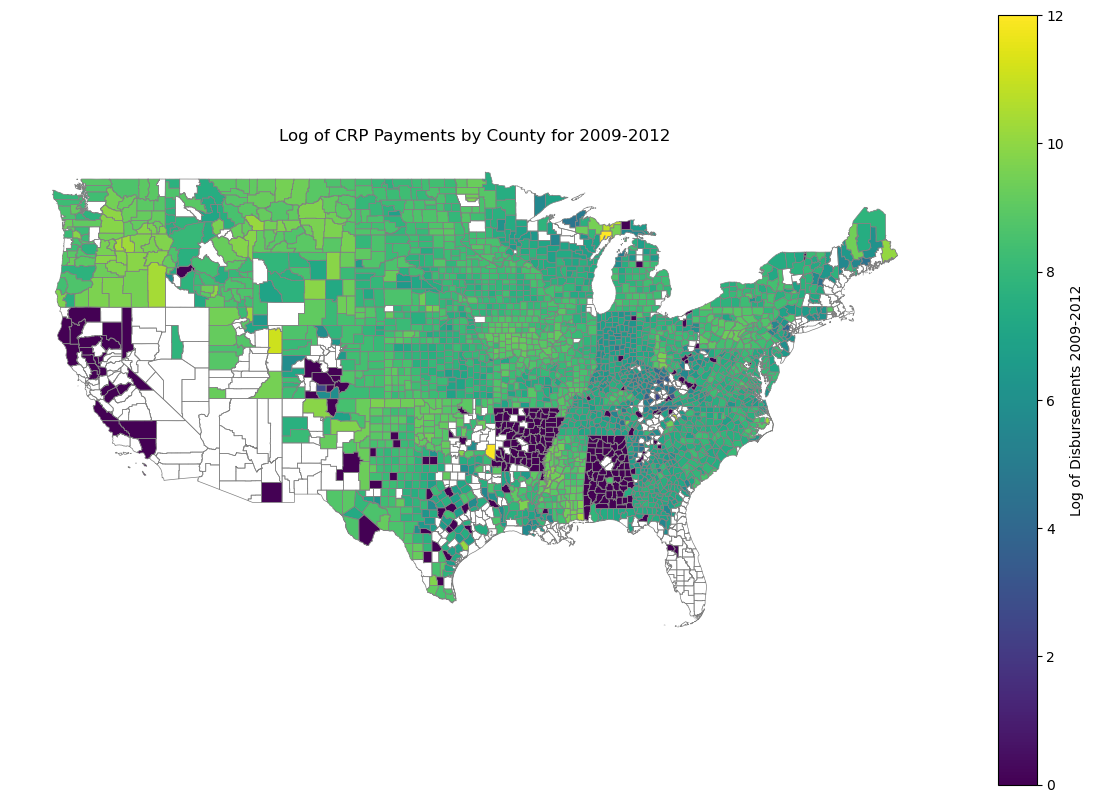

In [35]:
# Transform disbursements to logarithmic scale where necessary before plotting
# Use log1p to safely handle zero and near-zero values by adding 1 before log transformation
merged_data['log_2009-2012'] = np.log1p(merged_data['2009-2012'])

fig, ax = plt.subplots(1, figsize=(15, 10))
# Plot the counties with data
merged_data.plot(column='log_2009-2012', ax=ax, legend=True,
                 legend_kwds={'label': "Log of Disbursements 2009-2012", 'orientation': "vertical"})

# Plot all county outlines for context
counties.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=0.5)

ax.set_title('Log of CRP Payments by County for 2009-2012')
ax.set_axis_off()

# Save the figure
file_path = "C:/Users/ml124/Box/Jared\'s Project (shared)/Madi/2009to2012_payments.jpg"  # Specify your file path here
fig.savefig(file_path, format='jpeg')  # Save as JPEG
plt.show()

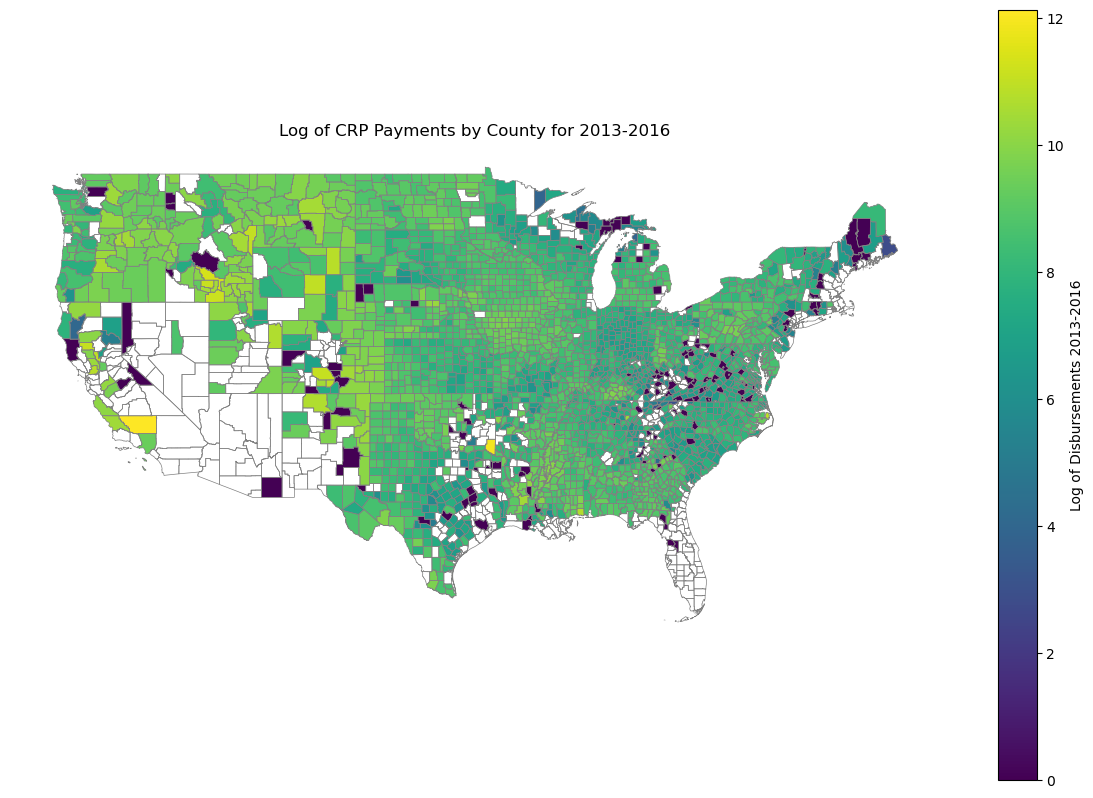

In [36]:
# Transform disbursements to logarithmic scale where necessary before plotting
# Use log1p to safely handle zero and near-zero values by adding 1 before log transformation
merged_data['log_2013-2016'] = np.log1p(merged_data['2013-2016'])

fig, ax = plt.subplots(1, figsize=(15, 10))
# Plot the counties with data
merged_data.plot(column='log_2013-2016', ax=ax, legend=True,
                 legend_kwds={'label': "Log of Disbursements 2013-2016", 'orientation': "vertical"})

# Plot all county outlines for context
counties.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=0.5)

ax.set_title('Log of CRP Payments by County for 2013-2016')
ax.set_axis_off()

# Save the figure
file_path = "C:/Users/ml124/Box/Jared\'s Project (shared)/Madi/2013to2016_payments.jpg"  # Specify your file path here
fig.savefig(file_path, format='jpeg')  # Save as JPEG
plt.show()

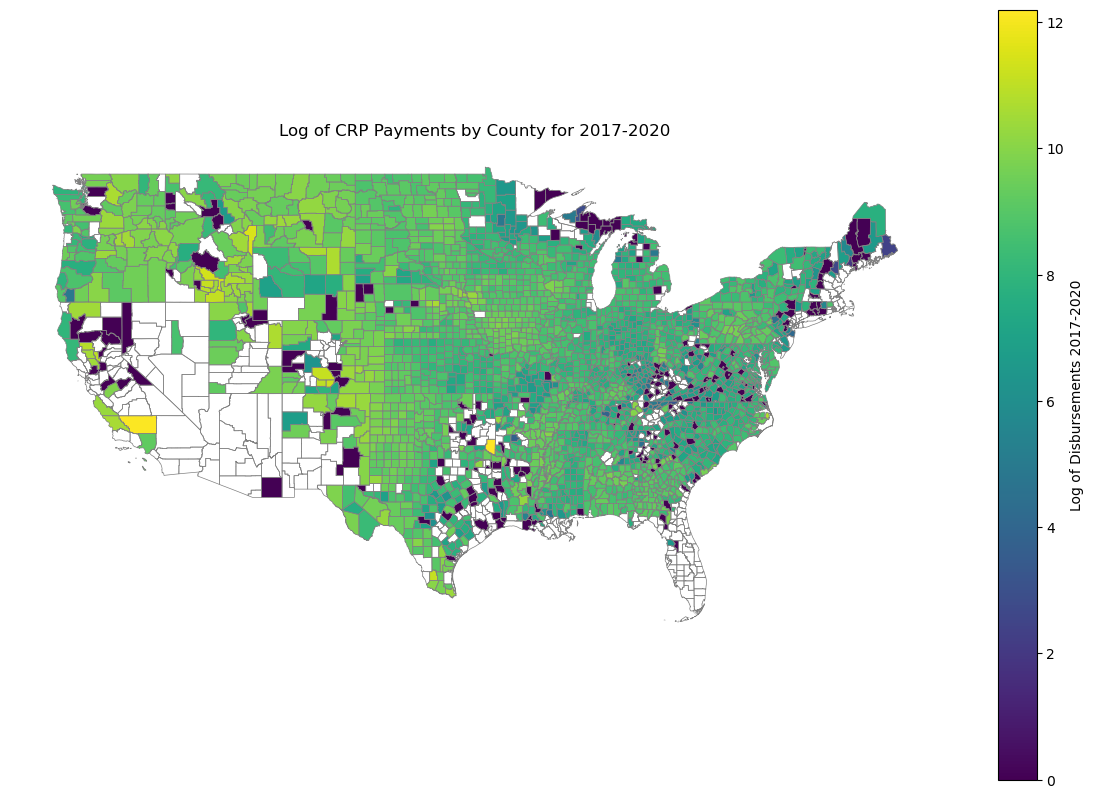

In [37]:
# Transform disbursements to logarithmic scale where necessary before plotting
# Use log1p to safely handle zero and near-zero values by adding 1 before log transformation
merged_data['log_2017-2020'] = np.log1p(merged_data['2017-2020'])

fig, ax = plt.subplots(1, figsize=(15, 10))
# Plot the counties with data
merged_data.plot(column='log_2017-2020', ax=ax, legend=True,
                 legend_kwds={'label': "Log of Disbursements 2017-2020", 'orientation': "vertical"})

# Plot all county outlines for context
counties.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=0.5)

ax.set_title('Log of CRP Payments by County for 2017-2020')
ax.set_axis_off()

# Save the figure
file_path = "C:/Users/ml124/Box/Jared\'s Project (shared)/Madi/2017to2020_payments.jpg"  # Specify your file path here
fig.savefig(file_path, format='jpeg')  # Save as JPEG
plt.show()